# Zwift

In [34]:
from IPython.display import display, clear_output, Markdown, HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from sklearn.linear_model import LinearRegression

register_matplotlib_converters()

#ROOT = r'G:\My Drive\Personal\Others\Zwift'
ROOT = '.'

## Rides

In [35]:
rides = pd.read_excel(os.path.join(ROOT, 'rides.xlsx'), parse_dates=['dtime'])
rides = rides.sort_values('dtime')
rides['totalminutes'] = rides['minutes'].cumsum()
rides['time'] = pd.to_timedelta(rides['time'])
rides['seconds'] = rides['time'] / np.timedelta64(1, 's')
rides['avg speed'] = rides['distance'] / (rides['minutes'] / 60)
rides['avg watt/kg'] = rides['avg_watt'] / rides['weight']
#display(rides[['dtime', 'title', 'type', 'distance', 'elevation', 'calories']])
rides = rides.iloc[1:]
display(rides)

,dtime,title,type,distance,totaldistance,elevation,totalelevation,calories,totalcalories,xp,...,minutes,avg_watt,normalized_power,avg_temp,avg_hr,avg_rpm,totalminutes,seconds,avg speed,avg watt/kg
1,2020-05-18 16:25:00,Fondo welcome workout,workout,16.40,33.80,134,182,352,256,602,...,52.333333,113.0,NaN,NaN,113.0,66.0,76.450000,3140.0,18.802548,1.361446
2,2020-05-19 07:00:00,Fondo - Introductory interval,workout,15.80,49.60,300,482,335,591,629,...,54.666667,106.0,NaN,33.0,130.0,79.0,131.116667,3280.0,17.341463,1.277108
3,2020-05-21 07:00:00,Fondo - The Long Ride,workout,25.00,74.60,168,650,407,998,747,...,64.983333,109.0,NaN,32.0,130.0,78.0,196.100000,3899.0,23.082842,1.313253
4,2020-05-22 07:00:00,FTP Builder Week 1,workout,13.80,88.40,138,788,246,1244,492,...,42.816667,100.0,NaN,32.0,121.0,76.0,238.916667,2569.0,19.338264,1.204819
5,2020-05-24 07:00:00,Fondo - Long tempo,workout,16.60,105.00,306,1094,353,1597,563,...,48.916667,127.0,NaN,33.5,138.0,82.0,287.833333,2935.0,20.361158,1.530120
6,2020-05-26 07:00:00,Fondo - Make A Break For It,workout,9.40,114.40,349,1443,356,1953,571,...,49.683333,134.0,NaN,32.0,138.0,82.0,337.516667,2981.0,11.351895,1.614458
7,2020-05-27 07:00:00,Workout,workout,11.30,125.70,136,1579,195,2148,351,...,32.516667,115.0,NaN,31.5,123.0,82.0,370.033333,1951.0,20.850846,1.385542
8,2020-05-28 09:46:00,Fondo - Long Ride,workout,30.80,156.50,279,1858,639,2787,1040,...,107.433333,129.0,NaN,NaN,NaN,NaN,477.466667,6446.0,17.201365,1.554217
9,2020-05-28 17:20:00,Recov interval,interval,6.40,162.90,22,1880,75,2862,223,...,20.866667,65.0,NaN,NaN,NaN,NaN,498.333333,1252.0,18.402556,0.783133
10,2020-05-29 06:00:00,The Fan Flats,ride,8.10,171.00,20,1900,91,2953,165,...,27.416667,64.0,NaN,NaN,NaN,NaN,525.750000,1645.0,17.726444,0.771084


## Progress

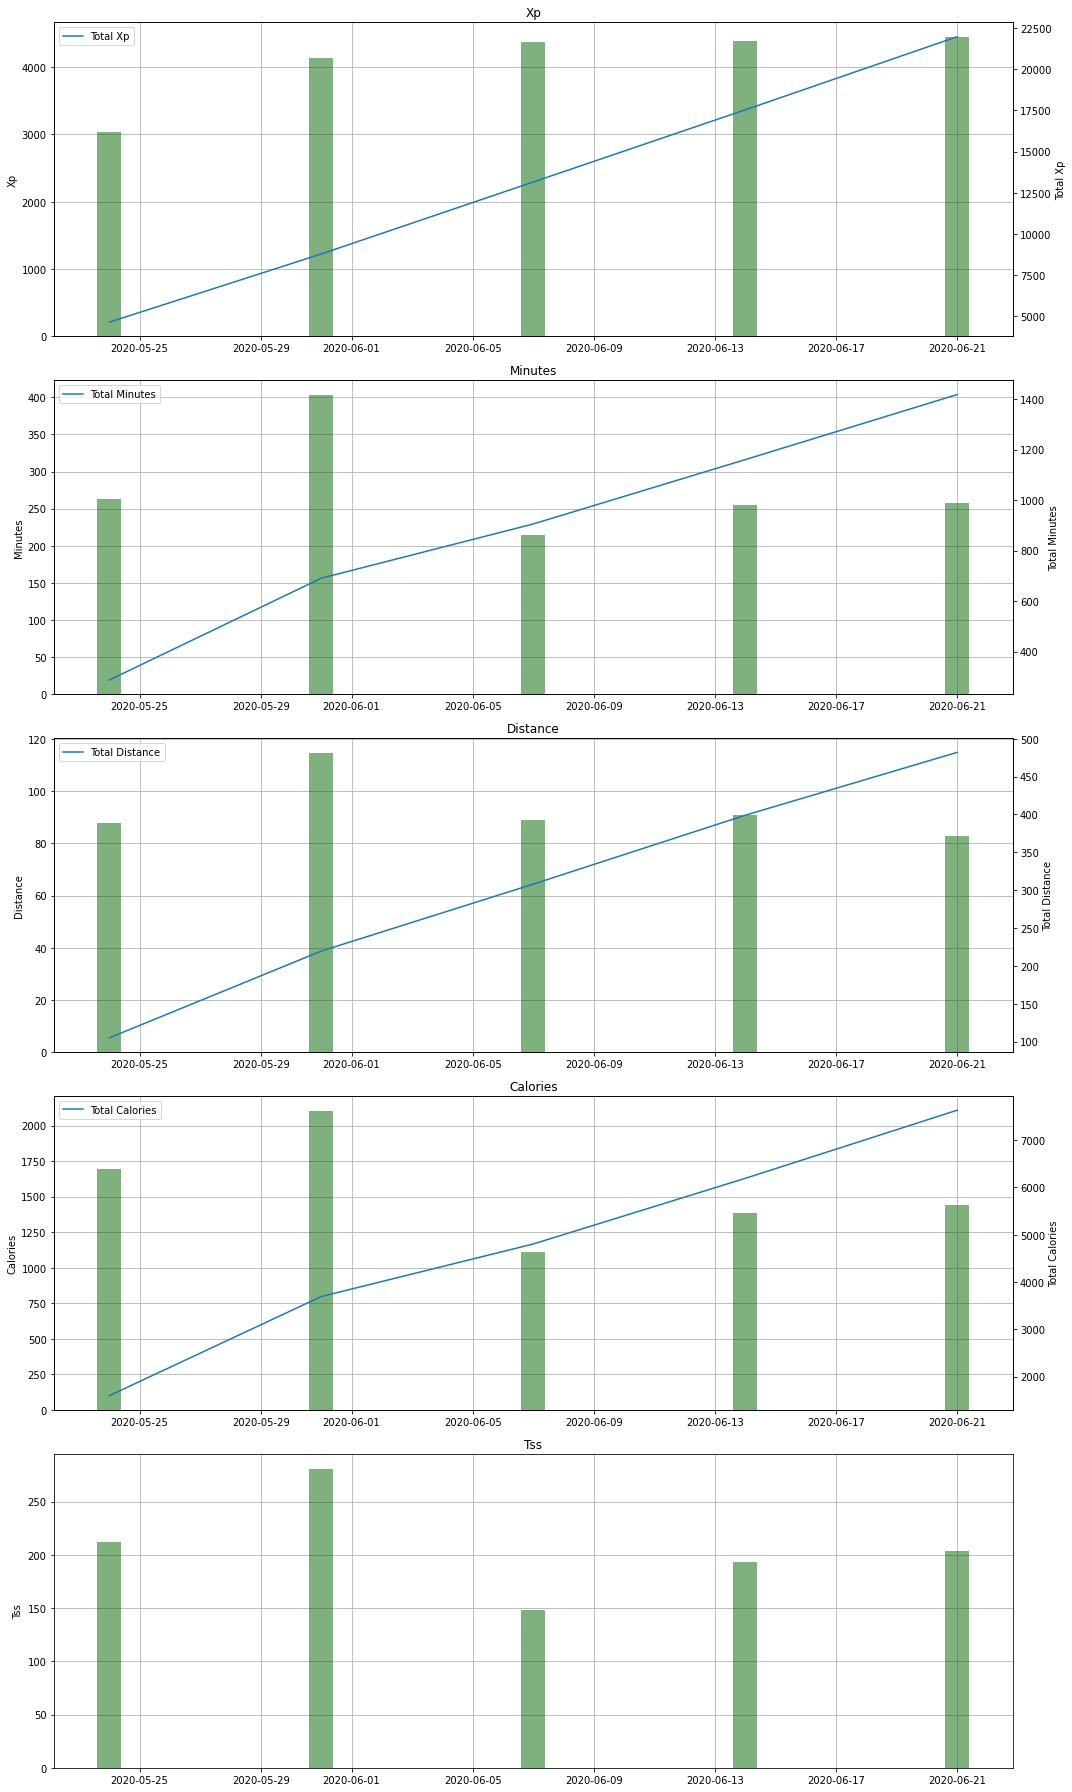

In [36]:
def plot_progress(interval):
    def _apply(subset):
        if len(subset)==0:
            return pd.Series({'xp': np.NaN,
                              'totalxp': np.NaN,
                              'calories': np.NaN,
                              'totalcalories': np.NaN,
                              'minutes': np.NaN,
                              'totalminutes': np.NaN,
                              'distance': np.NaN,
                              'totaldistance': np.NaN,
                              'tss': np.NaN})
        total_minutes = subset['minutes'].sum()
        avg_watt = (subset['avg_watt'] * subset['minutes']).sum() / total_minutes
        avg_ftp = subset['ftp'].mean()
        tss = (total_minutes / 60) * (avg_watt ** 2) / (avg_ftp ** 2) * 100
        #print(f'{subset.name} avg_watt:{avg_watt:.1f} total_minutes:{total_minutes:.0f} avg_ftp:{avg_ftp:.0f} tss:{tss:.1f}')
        return pd.Series({'xp': subset['xp'].sum(),
                          'totalxp': subset['totalxp'].iloc[-1],
                          'calories': subset['calories'].sum(),
                          'totalcalories': subset['totalcalories'].iloc[-1],
                          'minutes': subset['minutes'].sum(),
                          'totalminutes': subset['totalminutes'].iloc[-1],
                          'distance': subset['distance'].sum(),
                          'totaldistance': subset['totaldistance'].iloc[-1],
                          'tss': tss})
    
    #rides['ftp'] = 150
    df = rides[ rides['type'] != 'correction' ] \
                .set_index('dtime') \
                .groupby(pd.Grouper(freq=interval)) \
                .apply(_apply)
    
    metrics = ['xp', 'minutes', 'distance', 'calories', 'tss']
    fig, axis = plt.subplots(len(metrics), 1, figsize=(15,5*len(metrics)))
    
    for i_m, metric in enumerate(metrics):
        ax = axis[i_m]
        ax.set_title(metric.title())
        ax.bar(df.index, df[metric], color='darkgreen', alpha=0.5, zorder=5)
        ax.set_ylabel(f'{metric.title()}')
        ax.grid()
        #ax.legend()
        if f'total{metric}' in df.columns:
            ax_b = ax.twinx()
            ax_b.plot(df.index, df[f'total{metric}'], label=f'Total {metric.title()}', zorder=10)
            ax_b.set_ylabel(f'Total {metric.title()}')
        plt.legend()
        
    
    fig.tight_layout()
    
plot_progress('W-SUN')
#plot_progress('1D')

## Duration Predictor

In [37]:
df = rides
df = df[ df['dtime'] > '2020-06-01' ]
print(f'Using {len(df)} rides')
X = df[['distance', 'elevation', 'avg watt/kg']]
y = df['minutes']
reg = LinearRegression().fit(X, y)
pred = reg.predict(X)
mse = np.mean( (pred - y)**2 )
me = np.mean( mse ** 0.5 )
me_pct = np.mean( np.abs(pred-y) / y )
print(f'Mean error: {me:.1f} minutes')
print(f'Mean error: {me_pct:.1%}')

Using 10 rides
Mean error: 4.3 minutes
Mean error: 4.5%


## Most Profitable Routes

In [38]:
routes = pd.read_excel(os.path.join(ROOT, 'routes.xlsx'))
for col in ['done', 'badge', 'restriction', 'lead-in', 'elevation']:
    routes[col] = routes[col].fillna(0)

routes['restriction'] = routes['restriction'].fillna('').astype(str)
routes

,done,world,route,distance,elevation,lead-in,badge,restriction
0,0.0,Watopia,May Field,0.4,0.0,0.0,0.0,Run Only
1,0.0,Crit City,Bell Lap,1.9,8.0,0.1,0.0,Event Only
2,0.0,Crit City,Downtown Dolphin,1.9,8.0,0.1,0.0,Event Only
3,0.0,New York,Shuman Trail Loop Reverse,2.5,0.0,0.1,0.0,"Run Only, Event Only"
4,0.0,New York,Shuman Trail Loop,2.5,0.0,0.3,0.0,Run Only
...,...,...,...,...,...,...,...,...
121,0.0,Watopia,Four Horsemen,89.3,2112.0,0.6,1780.0,Level 6+
122,0.0,Watopia,Gran Fondo,97.2,1148.0,0.5,0.0,Event Only
123,0.0,Watopia,The Mega Pretzel,107.0,1642.0,3.7,2140.0,Level 5+
124,0.0,Watopia,The Über Pretzel,128.3,2335.0,0.5,2560.0,Level 6+


In [39]:
def best_route(avg_watt_per_kg, weight, max_duration, min_duration=None, kind=None, done=None):
    assert kind is None or kind in ['ride', 'interval', 'workout']
    max_minutes = pd.Timedelta(max_duration).total_seconds() / 60
    df = routes.copy()
    
    # In "ride" mode, Zwift awards 20 xp per km
    XP_PER_KM = 20
    
    # In "interval", reward is 12 XP per minute. But there will be other
    # blocks such as warmups and free rides so usually we won't get the full XPs
    XP_PER_MIN_ITV = 12 * 0.95
    
    # In "workout" blocks, reward is 10 XP per minute for workout blocks and
    # 5-6 XP per minute for warmup/rampup/cooldown/rampdown blocks.
    XP_PER_MIN_WRK = 10 * 0.8 + 5.5 * 0.2
    
    df = df[ ~df['restriction'].str.contains('Run') ]
    df = df[ ~df['restriction'].str.contains('Event') ]
    df = df.set_index(['world', 'route'])
    df['total distance'] = df['distance'] + df['lead-in']
    df['avg watt'] = avg_watt_per_kg * weight
    df['avg watt/kg'] = avg_watt_per_kg
    
    # Set for better display
    df[['done', 'elevation', 'badge']] = df[['done', 'elevation', 'badge']].astype(int)
    
    # Clear badge if route is done
    df.loc[df['done'] != 0, 'badge'] = 0
    
    # Predict ride duration using linear regressor
    df['pred minutes'] = reg.predict(df[['total distance', 'elevation', 'avg watt/kg']]).round(1)
    df['pred avg speed'] = (df['total distance'] / (df['pred minutes'] / 60.0)).round(1)
    
    # Predict the XPs received for ride and interval activities, assuming that we finish
    # the full route.
    df['pred xp (ride)'] = (np.floor(df['total distance']) * XP_PER_KM + df['badge']).astype(int)
    df['pred xp (interval)'] = (np.floor(df['pred minutes']) * XP_PER_MIN_ITV + df['badge']).astype(int)
    df['pred xp (workout)'] = (np.floor(df['pred minutes']) * XP_PER_MIN_WRK + df['badge']).astype(int)
    
    # Set which is the best activity (ride or interval), unless it's forced
    if not kind:
        df['best activity'] = df[['pred xp (ride)', 'pred xp (interval)', 'pred xp (workout)']].idxmax(axis=1)
        df['best activity'] = df['best activity'].str.extract(r'\((.*)\)')

        # Set the best XP received if the best activity is selected
        df['best pred xp'] = df[['pred xp (ride)', 'pred xp (interval)', 'pred xp (workout)']].max(axis=1)
    else:
        df['best activity'] = kind
        df['best pred xp'] = df[f'pred xp ({kind})']
        
    df['best pred xp/minutes'] = (df['best pred xp'] / df['pred minutes']).round(1)
    
    # Filter only routes less than the specified duration
    df = df[ df['pred minutes'] <= max_minutes]
    
    # Filter only routes with at least the specified duration
    if min_duration:
        min_minutes = pd.Timedelta(min_duration).total_seconds() / 60
        df = df[ df['pred minutes'] > min_minutes]
        
    # Display result
    columns = ['done', 'total distance', 'distance', 'lead-in', 'elevation', 'badge', 
               'best activity', 'best pred xp', 'avg watt', 'avg watt/kg', 'pred avg speed', 
               'pred minutes', 'best pred xp/minutes']
    df = df[columns]
    df['avg watt'] = df['avg watt'].astype(int)
    df['avg watt/kg'] = df['avg watt/kg'].round(2)
    #df = df.sort_values(['best pred xp/minutes'], ascending=False)
    df = df.sort_values(['best pred xp'], ascending=False)
    if done is not None:
        df = df[ df['done']==done ]
        
    return df

def best_route_by_watt(avg_watt, weight, duration, kind=None, done=None):
    duration = pd.Timedelta(duration)
    min_duration = duration - pd.Timedelta(minutes=5)
    max_duration = duration + pd.Timedelta(minutes=5)
    return best_route(avg_watt/weight, weight, max_duration, min_duration=min_duration, 
                      kind=kind, done=done)
    
def calc_avg_watt(ftp, tss, duration):
    # TSS = hour * avg_watt**2 / ftp**2 * 100
    # avg_watt = (tss / hour * ftp**2 / 100) ** 0.5
    hour = pd.Timedelta(duration).total_seconds() / 3600
    return (tss * (ftp**2) / hour / 100) ** 0.5
    
def calc_tss(ftp, avg_watt, duration):
    #np = avg_watt
    #IF = np / ftp
    #tss = (pd.Timedelta(duration).total_seconds()  * np * IF) / (ftp * 3600) * 100
    tss = pd.Timedelta(duration).total_seconds() / 3600 * (avg_watt ** 2) / (ftp ** 2) * 100
    return tss

def best_route_by_tss(ftp, weight, tss, duration, kind=None, done=None):
    duration = pd.Timedelta(duration)
    avg_watt = calc_avg_watt(ftp, tss, duration)
    return best_route(avg_watt/weight, weight, duration+pd.Timedelta(minutes=10), 
                      min_duration=duration-pd.Timedelta(minutes=10), 
                      kind=kind, done=done)

# Monday: Step-down interval
#best_route_by_tss(160, 83, 62, '0:50:00', kind='workout')

# Tuesday: Low-cadence interval
#best_route_by_tss(160, 83, 53, '0:50:00', kind='workout')

# Thursday: The long ride
#best_route_by_tss(160, 83, 42, '0:50:00', kind='interval')

# MAF Rest day
#best_route(84/83, 83, '0:35:00')
#best_route_by_tss(160, 83, 16, '0:25:00')

# MAF M8070
best_route(111/83, 83, '1:20:00')

done  total distance  distance  \
world     route                                                               
London    Greatest London Flat                  0            31.1      23.6   
New York  Rising Empire                         0            21.1      20.7   
          Mighty Metropolitan                   0            20.4      20.0   
London    London 8                              0            20.8      20.3   
Watopia   Sand and Sequoias                     0            22.6      20.2   
          Tick Tock                             0            19.2      16.8   
London    Greatest London Loop                  1            26.1      25.6   
New York  The Highline                          0            20.5      10.5   
London    London Loop                           0            15.4      14.9   
New York  Knickerbocker Reverse                 1            22.7      22.5   
          Knickerbocker                         1            22.9      22.5   
Watopia   Whole Lotta Lava                      0            17.2      12.3   
          Volcano Climb                         1            23.3      22.8   
New York  Lady Liberty                          0            12.7      12.3   
London    Greater London Loop                   1            21.5      21.0   
Watopia   Jungle Circuit                        0            13.6       7.9   
          Volcano Circuit 5 laps                1            23.3      20.5   
New York  Astoria Line 8                        0            11.9      11.5   
Yorkshire Tour of Tewit Well                    0            10.4      10.4   
Watopia   Volcano Flat                          0            12.8      12.3   
New York  Park Perimeter Loop                   0            10.2       9.8   
Yorkshire 2019 UCI Worlds Harrogate Circuit     1            13.9      13.8   
Richmond  2015 UCI Worlds Course                1            16.7      16.2   
          Cobbled Climbs                        0             9.5       9.2   
Watopia   Flat Route                            0            10.8      10.3   
          Tempus Fugit                          1            19.7      17.3   
          Hilly Route                           0             9.6       9.1   
London    Greater London Flat                   1            17.3      11.6   
New York  Grand Central Circuit                 0             8.4       6.8   
          The 6 Train                           0             6.6       6.4   
Watopia   Volcano Circuit CCW                   0             9.0       4.1   
New York  Gotham Grind                          0             9.6       9.3   
London    Classique                             1            11.1       5.4   
Yorkshire Queen's Highway                       0             5.8       3.0   
Innsbruck Innsbruckring                         1             9.0       8.8   
Richmond  The Fan Flats                         1             9.3       5.0   
Watopia   Volcano Circuit                       1             6.9       4.1   
Yorkshire Duchy Estate                          1             4.7       3.0   

                                             lead-in  elevation  badge  \
world     route                                                          
London    Greatest London Flat                   7.5        163    500   
New York  Rising Empire                          0.4        362    410   
          Mighty Metropolitan                    0.4        307    400   
London    London 8                               0.5        255    410   
Watopia   Sand and Sequoias                      2.4        147    400   
          Tick Tock                              2.4         44    388   
London    Greatest London Loop                   0.5        345      0   
New York  The Highline                          10.0        175    210   
London    London Loop                            0.5        220    300   
New York  Knickerbocker Reverse                  0.2        364      0

## Running Planner

In [40]:
def running_best_route(pace, max_duration, min_duration=None, kind=None, done=None):
    assert kind is None or kind in ['run', 'interval', 'workout']
    max_minutes = pd.Timedelta(max_duration).total_seconds() / 60
    df = routes.copy()
    
    # In "run" mode, Zwift awards 10 xp per 0.25 km
    XP_PER_250M = 10
    
    # In "interval", reward is 12 XP per minute. But there will be other
    # blocks such as warmups and free rides so usually we won't get the full XPs
    XP_PER_MIN_ITV = 12 * 0.95
    
    # In "workout" blocks, reward is 10 XP per minute for workout blocks and
    # 5-6 XP per minute for warmup/rampup/cooldown/rampdown blocks.
    XP_PER_MIN_WRK = 10 * 0.8 + 5.5 * 0.2
    
    #df = df[ ~df['restriction'].str.contains('Run') ]
    df = df[ ~df['restriction'].str.contains('Event') ]
    df = df.set_index(['world', 'route'])
    df['total distance'] = df['distance'] + df['lead-in']
    df['pace'] = pace
    df['speed'] = round(60/pace, 1)
    
    # Set for better display
    df[['done', 'elevation', 'badge']] = df[['done', 'elevation', 'badge']].astype(int)
    
    # Clear badge if route is done
    df.loc[df['done'] != 0, 'badge'] = 0
    
    # Predict ride duration using linear regressor
    df['pred minutes'] = df['total distance'] * pace
    
    # Predict the XPs received for ride and interval activities, assuming that we finish
    # the full route.
    df['pred xp (run)'] = (np.floor(df['total distance'] * 4) * XP_PER_250M + df['badge']).astype(int)
    df['pred xp (interval)'] = (np.floor(df['pred minutes']) * XP_PER_MIN_ITV + df['badge']).astype(int)
    df['pred xp (workout)'] = (np.floor(df['pred minutes']) * XP_PER_MIN_WRK + df['badge']).astype(int)
    
    # Set which is the best activity (run or interval), unless it's forced
    if not kind:
        df['best activity'] = df[['pred xp (run)', 'pred xp (interval)', 'pred xp (workout)']].idxmax(axis=1)
        df['best activity'] = df['best activity'].str.extract(r'\((.*)\)')

        # Set the best XP received if the best activity is selected
        df['best pred xp'] = df[['pred xp (run)', 'pred xp (interval)', 'pred xp (workout)']].max(axis=1)
    else:
        df['best activity'] = kind
        df['best pred xp'] = df[f'pred xp ({kind})']
        
    df['best pred xp/minutes'] = (df['best pred xp'] / df['pred minutes']).round(1)
    
    # Filter only routes less than the specified duration
    df = df[ df['pred minutes'] <= max_minutes]
    
    # Filter only routes with at least the specified duration
    if min_duration:
        min_minutes = pd.Timedelta(min_duration).total_seconds() / 60
        df = df[ df['pred minutes'] > min_minutes]
        
    # Display result
    columns = ['done', 'total distance', 'distance', 'lead-in', 'elevation', 'badge', 
               'best activity', 'best pred xp', 'pace', 'speed', 'pred minutes', 'best pred xp/minutes']
    df = df[columns]
    #df = df.sort_values(['best pred xp/minutes'], ascending=False)
    df = df.sort_values(['best pred xp'], ascending=False)
    if done is not None:
        df = df[ df['done']==done ]
        
    return df


running_best_route(9.5, '0:60:00', min_duration='0:20:00', kind='workout')

,,done,total distance,distance,lead-in,elevation,badge,best activity,best pred xp,pace,speed,pred minutes,best pred xp/minutes
world,route,,,,,,,,,,,,
Watopia,5K Loop,0,5.3,5.0,0.3,0,200,workout,655,9.5,6.3,50.35,13.0
New York,Park to Peak,0,4.7,4.6,0.1,0,180,workout,580,9.5,6.3,44.65,13.0
Yorkshire,Queen's Highway,0,5.8,3.0,2.8,121,60,workout,560,9.5,6.3,55.10,10.2
Watopia,Run Path Reverse,0,5.3,5.0,0.3,0,0,workout,455,9.5,6.3,50.35,9.0
Yorkshire,Duchy Estate,1,4.7,3.0,1.7,40,0,workout,400,9.5,6.3,44.65,9.0
New York,Shuman Trail Loop,0,2.8,2.5,0.3,0,0,workout,236,9.5,6.3,26.60,8.9
